In [5]:
import mediapipe as mp
import cv2
import numpy as np
import skatePoseModule as spm
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import random

In [6]:
psd = spm.poseDetector(min_detection_confidence=0.8, min_tracking_confidence=0.2, model_complexity=2)

In [7]:
mp_pose = mp.solutions.pose
mp_drawing = mp.solutions.drawing_utils 
mp_drawing_styles = mp.solutions.drawing_styles
mp_holistic = mp.solutions.holistic # Mediapipe Solutions

### 1. 동영상 절반으로 이등분하고 프레임별로 나누기

In [34]:
###################동영상의 경로를 지정해줘야 합니다######################################
cap = cv2.VideoCapture('./data/1.mp4')
###################동영상의 경로를 지정해줘야 합니다######################################

w = round(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
h = round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = cap.get(cv2.CAP_PROP_FPS)

fourcc = cv2.VideoWriter_fourcc(*'DIVX')
delay = round(1000/fps)
w_half = (int)(w/2)
################### 반으로 쪼갠 뒤 각각의 영상을 저장할 위치를 지정합니다(확장자는 반드시 avi로)######################################
out1 = cv2.VideoWriter('./1/output.avi', fourcc, fps, (w_half, h))
out2 = cv2.VideoWriter('./2/output.avi', fourcc, fps, (w_half, h))
################### 반으로 쪼갠 뒤 각각의 영상을 저장할 위치를 지정합니다(확장자는 반드시 avi로)######################################

image1 = np.ndarray([])

flag = 0

# 영상을 절반으로 나누어 각 프레임별로 저장
while True:
    ret, frame = cap.read()
    
    if not ret : 
        break
    
    frame1 = frame[:,:w_half]
    frame2 = frame[:,w_half:]
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
        
    out1.write(frame1)
    out2.write(frame2)
    ################### 반으로 쪼갠 뒤 각각의 프레임들을 저장할 위치를 지정합니다.######################################
    cv2.imwrite('./1/%d.jpg' % (flag), frame1)
    cv2.imwrite('./2/%d.jpg' % (flag), frame2)
    ################### 반으로 쪼갠 뒤 각각의 프레임들을 저장할 위치를 지정합니다.######################################
    flag += 1
    
cap.release()
out1.release()
out2.release()
cv2.destroyAllWindows()

### 2. 프레임별로 나눠서 각 로컬폴더에 저장된 프레임들 불러와서 각도 계산(구현)

In [8]:
import os
import os.path

# 필요한 관절 각도를 구하는 함수
def getAngleLists(img, lmlist, rightLegAngleList, leftLegAngleList, rightGolbanAngleList, leftGolbanAngleList):
    with mp_pose.Pose(min_detection_confidence=0.6, min_tracking_confidence=0.7, model_complexity=2) as pose:
        image = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        results = pose.process(image)
        
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        
        try:
            landmarks = results.pose_landmarks.landmark
        except:
            pass
                
        if results.pose_landmarks is not None:
            mypose = results.pose_landmarks
            tmpList = []
            for idx,lm in enumerate(mypose.landmark):
                point=np.array([lm.x, lm.y, lm.z])
                tmpList.append(point)
            
            rightLegAngleList.append(psd.findAngle3D(tmpList[24][1:],tmpList[26][1:],tmpList[28][1:]))
            leftLegAngleList.append(psd.findAngle3D(tmpList[23][1:],tmpList[25][1:],tmpList[27][1:]))
            rightGolbanAngleList.append(psd.findAngle3D(tmpList[12][1:],tmpList[24][1:],tmpList[26][1:]))
            leftGolbanAngleList.append(psd.findAngle3D(tmpList[11][1:],tmpList[23][1:],tmpList[25][1:]))
            
            for i in range(10):
                del tmpList[13]
            lmlist.append(tmpList)
        else:
            print("no landmark")

# 미리 분류된 사진의 폴더에서 모든 사진에 대해 접근. getAngleLists 함수를 사용해 모든 사진의 주요 관절 각도 배열을 생성
def search_file(dir, lmlist, rightLegAngleList, leftLegAngleList, rightGolbanAngleList, leftGolbanAngleList):
    files = os.listdir(dir)
    
    for data in files:
        if (os.path.isdir(dir+r"/"+data) == True):
            search_file(dir+r"/"+data)
        else:
            img = cv2.imread(dir+r"/"+data)
            getAngleLists(img, lmlist, rightLegAngleList, leftLegAngleList, rightGolbanAngleList, leftGolbanAngleList)

In [9]:
lmlist = []
rightLegAngleList = []
leftLegAngleList = []
rightGolbanAngleList = []
leftGolbanAngleList = []

In [23]:
################### 매우 중요 매우 중요 매우 즁요 ㅁ애우 중요 매우 쥬ㅜㅇ요 ######################################
################### 각 자세 별로 미리 저장해둔 프레임들이 저장된 경로를 적어줘야 합니다.######################################
dir = "./2/right"
################### 각 자세 별로 미리 저장해둔 프레임들이 저장된 경로를 적어줘야 합니다.######################################
################### 매우 중요 매우 중요 매우 즁요 ㅁ애우 중요 매우 쥬ㅜㅇ요 ######################################


search_file(dir, lmlist, rightLegAngleList, leftLegAngleList, rightGolbanAngleList, leftGolbanAngleList)

no landmark
no landmark
no landmark
no landmark
no landmark
no landmark
no landmark
no landmark
no landmark
no landmark
no landmark
no landmark
no landmark
no landmark
no landmark
no landmark


### 3. 관절 각도 잘 나왔나 확인해보기

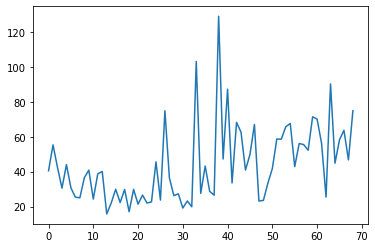

In [24]:
import matplotlib.pyplot as plt

start = 0
end = len(leftLegAngleList)
y = range(start, end)
plt.plot(y, np.array(leftLegAngleList)[start:end])
plt.show()

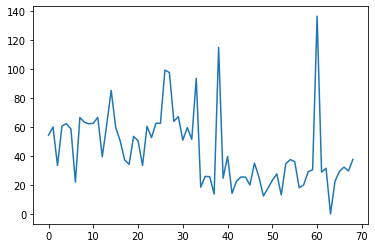

In [25]:
import matplotlib.pyplot as plt

start = 0
end = len(rightLegAngleList)
y = range(start, end)
plt.plot(y, np.array(rightLegAngleList)[start:end])
plt.show()

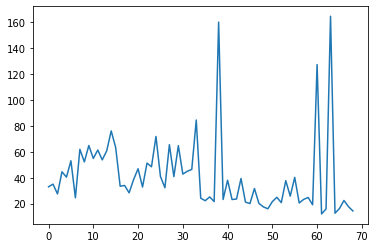

In [26]:
import matplotlib.pyplot as plt

start = 0
end = len(rightGolbanAngleList)
y = range(start, end)
plt.plot(y, np.array(rightGolbanAngleList)[start:end])
plt.show()

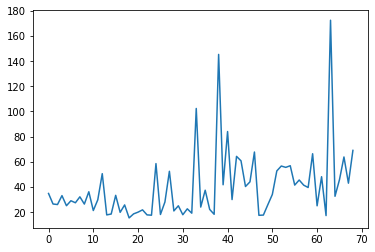

In [27]:
import matplotlib.pyplot as plt

start = 0
end = len(leftGolbanAngleList)
y = range(start, end)
plt.plot(y, np.array(leftGolbanAngleList)[start:end])
plt.show()

### 4. 랜드마크 좌표 배열과 관절 각도 배열을 합치기 (concat)

In [28]:
lm = []
for i in lmlist:
    lm.append(list(np.array(i).flatten()))

In [29]:
c_lmlist = np.c_[np.array(lm), np.array(rightLegAngleList), np.array(leftLegAngleList), np.array(rightGolbanAngleList), np.array(leftGolbanAngleList)]

c_lm = []
for i in c_lmlist:
    c_lm.append(list(np.array(i).flatten()))

In [30]:
c_lm

[[0.4898087978363037,
  0.5415399074554443,
  -0.4374147653579712,
  0.4941243529319763,
  0.5339327454566956,
  -0.43931716680526733,
  0.49720513820648193,
  0.5331933498382568,
  -0.43950435519218445,
  0.4997509717941284,
  0.5325186848640442,
  -0.43952876329421997,
  0.48588958382606506,
  0.5340433120727539,
  -0.43316686153411865,
  0.48352423310279846,
  0.5333985686302185,
  -0.4333701431751251,
  0.48133406043052673,
  0.5326905250549316,
  -0.43346282839775085,
  0.5066820979118347,
  0.5294119119644165,
  -0.3749770522117615,
  0.48245328664779663,
  0.5306651592254639,
  -0.34551870822906494,
  0.49576708674430847,
  0.5448085069656372,
  -0.4062359631061554,
  0.48885655403137207,
  0.5457372665405273,
  -0.39858686923980713,
  0.5405284762382507,
  0.5363253355026245,
  -0.28109821677207947,
  0.47469037771224976,
  0.5480669736862183,
  -0.23120002448558807,
  0.5358876585960388,
  0.6046741008758545,
  -0.027503564953804016,
  0.5004382133483887,
  0.6045011878013611,

### 5. csv파일로 저장하기

In [33]:
import csv 

############# csv파일명을 바꿔가며 저장하기. 각 자세별로 다른 csv파일에 저장하기 ###############
with open('./csv/right.csv', 'a', newline='') as myfile:
    wr = csv.writer(myfile) 
    for i in c_lm:
        wr.writerow(i)
############# csv파일명을 바꿔가며 저장하기. 각 자세별로 다른 csv파일에 저장하기 ###############